In [29]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy import stats
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Loading in datasets

#### (a) Dataset for Credit Default Swap spreads

In [2]:
cds_DF = pd.read_csv("datasets/cds.csv", parse_dates=['Date'])
cds_DF.head()

,Date,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
0,2015-01-01,A,Agilent Technologies Inc,14.850,25.05,39.055,73.715,86.30,111.305,125.905,144.300,158.600,168.195
1,2015-01-02,A,Agilent Technologies Inc,14.855,25.15,39.160,73.600,86.40,111.510,126.100,144.375,158.775,168.375
2,2015-01-05,A,Agilent Technologies Inc,13.455,24.96,39.310,70.200,88.26,111.970,125.060,143.165,157.385,166.825
3,2015-01-06,A,Agilent Technologies Inc,15.535,24.88,39.300,72.680,91.10,116.610,130.890,150.365,165.655,175.885
4,2015-01-07,A,Agilent Technologies Inc,15.215,25.50,40.270,73.880,92.50,117.780,131.940,151.145,166.215,176.295


#### (b) Dataset for equities of different companies

In [3]:
comp_stocks_DF = pd.read_csv("datasets/company_stock_data.csv", index_col='Date', parse_dates=True)
comp_stocks_DF.head()

,A,AAPL,ABBV,ABT,ADM,ADP,AES,AFG,AGR,AIG,...,WEC,WELL,WFC,WHR,WM,WMB,WMT,WU,WY,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,37.422062,24.347172,43.563179,37.108746,39.133045,67.362991,9.684173,30.017288,NaN,44.253033,...,38.417412,51.027782,41.032391,135.059799,42.477646,25.322723,23.493425,11.352100,24.284630,60.042534
2015-01-05,36.720852,23.661274,42.743362,37.117004,37.778957,67.314476,9.408492,29.623707,NaN,43.377602,...,37.947937,51.657738,39.907192,132.274841,42.050804,24.320345,23.425055,11.244470,24.284630,58.399651
2015-01-06,36.148819,23.663500,42.531784,36.695503,37.034214,66.756416,9.196430,29.454308,NaN,42.762428,...,38.049053,52.393814,39.074547,131.183243,42.083641,23.989943,23.605558,11.225472,24.257740,58.089199
2015-01-07,36.628582,23.995317,44.250786,36.993034,37.590893,67.338745,9.210567,29.648619,NaN,42.967476,...,38.518543,52.877903,39.307091,134.269150,42.116470,23.861147,24.231873,11.117839,24.331717,58.677792
2015-01-08,37.726505,24.917271,44.713577,37.753399,37.041733,68.883507,9.351940,30.186687,NaN,42.778191,...,38.944660,52.659077,40.177235,137.732925,42.600754,24.090736,24.743311,11.339439,24.593996,59.654469


#### (c) Dataset for total asset value and total debt vale of companies

In [38]:
quarterly_DF = pd.read_csv("datasets/quarterly_company_data.csv", parse_dates=['datadate'])
quarterly_DF.head()

,gvkey,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,tic,cusip,...,costat,dvpspq,dvpsxq,mkvaltq,gind,gsector,gsubind,idbflag,naics,spcsrc
0,1078,2014-12-31,2014,4.0,INDL,C,D,STD,ABT,002824100,...,A,0.22,0.22,67891.7357,351010.0,35.0,35101010.0,B,334510,B+
1,1078,2015-03-31,2015,1.0,INDL,C,D,STD,ABT,002824100,...,A,0.24,0.24,68974.1118,351010.0,35.0,35101010.0,B,334510,B+
2,1078,2015-06-30,2015,2.0,INDL,C,D,STD,ABT,002824100,...,A,0.24,0.24,73150.8443,351010.0,35.0,35101010.0,B,334510,B+
3,1078,2015-09-30,2015,3.0,INDL,C,D,STD,ABT,002824100,...,A,0.24,0.24,59996.9784,351010.0,35.0,35101010.0,B,334510,B+
4,1078,2015-12-31,2015,4.0,INDL,C,D,STD,ABT,002824100,...,A,0.24,0.24,66137.3852,351010.0,35.0,35101010.0,B,334510,B+


#### (d) risk free rate series

In [42]:
risk_free_rate_S = web.DataReader('TB3MS', 'fred', start=quarterly_DF['datadate'].min().strftime('%Y-%m-%d'), 
                                  end=quarterly_DF['datadate'].max().strftime('%Y-%m-%d'))

## 2. Processing data

In [215]:
def create_correct_dataframe(comp_tick):
    """This function will given an ticker name of a company create a dataframe that is necessary for the
    implied CDS-spread model. The only prerequisite is that the above code is run and hence the right
    .csv files are loaded in"""
    #fetch quarterly comp data for atq and ltq
    temp_comp_quarter = quarterly_DF[quarterly_DF['tic'] == comp_tick][['datadate','atq','ltq','cshoq']]

    #create a date range of comp data in days
    quart_to_days = pd.date_range(start=temp_comp_quarter['datadate'].min(), end=temp_comp_quarter['datadate'].max())
    
    #set the previously made date range as index
    temp_comp_quarter = temp_comp_quarter.set_index('datadate').reindex(quart_to_days).reset_index(names='datadate')

    #interpolate for the NaN values in lineair fashion
    temp_comp_quarter = temp_comp_quarter.interpolate(method='linear', limit_direction='forward', axis=0).set_index('datadate')

    #load equity data of company ticker
    temp_comp_equity = comp_stocks_DF[comp_tick]
    
    #combine the datasets on same dates
    temp_comp_comb = pd.merge(temp_comp_quarter, temp_comp_equity, left_index=True, right_index=True)

    #add column for log returns for both equity and total asset values
    temp_comp_comb['log_returns_eq'] = np.log(temp_comp_comb[comp_tick] / temp_comp_comb[comp_tick].shift(1))
    temp_comp_comb['log_returns_as'] = np.log(temp_comp_comb['atq'] / temp_comp_comb['atq'].shift(1))*252 #This I dont know about

    #Add the actual CDS data
    temp_comp_CDS = cds_DF[cds_DF['Ticker'] == comp_tick][['Date', 'PX1', 'PX2', 'PX3', 'PX4', 'PX5', 'PX6', 'PX7', 'PX8', 'PX9', 'PX10']].set_index('Date')
    temp_comp_comb = pd.merge(temp_comp_comb, temp_comp_CDS, left_index=True, right_index=True)

    #Add the riskfree rate data
    temp_comp_comb['rfree'] = risk_free_rate_S.reindex(temp_comp_comb.index, method='bfill')

    return temp_comp_comb

#example usage
create_correct_dataframe('AAPL').head()

,atq,ltq,cshoq,AAPL,log_returns_eq,log_returns_as,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10,rfree
2015-01-02,261878.444444,138424.266667,5824.993644,24.347172,NaN,NaN,8.300,11.100,12.900,16.800,23.600,31.805,36.705,42.800,47.605,51.60,0.02
2015-01-05,261855.111111,138211.666667,5822.855611,23.661274,-0.028576,-0.022454,9.535,12.800,14.890,19.415,27.290,36.520,41.860,48.455,53.560,57.77,0.02
2015-01-06,261847.333333,138140.800000,5822.142933,23.663500,0.000094,-0.007485,7.820,10.455,12.145,15.815,22.225,30.110,34.905,40.905,45.670,49.67,0.02
2015-01-07,261839.555556,138069.933333,5821.430256,23.995317,0.013925,-0.007485,7.835,10.475,12.175,15.860,22.300,30.220,35.035,41.065,45.850,49.86,0.02
2015-01-08,261831.777778,137999.066667,5820.717578,24.917271,0.037702,-0.007486,7.805,10.440,12.130,15.800,22.215,30.115,34.910,40.920,45.695,49.70,0.02


In [164]:
#load all used ticker names in a list.
with open('datasets/tickers.txt', 'r') as ticks:
    tickers = ticks.read().split('\n')[:-1]

In [165]:
#create a dictionary with ticker names and corresponding dataframe created by create_correct_dataframe()
ticks_DF_dict = {}
for tick in tickers:
    try:
        ticks_DF_dict[tick] = create_correct_dataframe(tick)
    except:
        print(tick, end=', ')

BMO, BNS, BRK, CM, MUV2.DE, RY, TD, 

## 3. Defining model and calculating implied spread

In [166]:
def BS_implied_spread(asset_0, debt, T, r, sigma_asset):
    
    leverage = (debt * np.exp(-r * T)) / asset_0 
    d1 = (np.log(asset_0) - np.log(debt) + (r + sigma_asset**2 / 2) * T) / (sigma_asset * np.sqrt(T))
    d2 = d1 - sigma_asset * np.sqrt(T)

    implied_spread = -np.log((stats.norm.cdf(d2) + (stats.norm.cdf(-d1) / leverage)) / T)
    return implied_spread

In [173]:
#Calculate Imp-spread for every company
for tick, DF in ticks_DF_dict.items():
    daily_vol = np.std(DF['log_returns_as'].dropna())
    annualized_vol_naive = daily_vol * np.sqrt(252)

    DF['imp_spread'] = BS_implied_spread(DF['atq']/DF['cshoq'], DF['ltq']/DF['cshoq'], 1, DF['rfree'], annualized_vol_naive)

A, AAPL, ABBV, ABT, ADM, ADP, AES, AFG, AGR, AIG, ALL, ALLY, AMAT, AMGN, AMP, AMT, AMZN, AN, APD, ARW, ASML, AVB, AVT, AVY, AXP, AZN, AZO, BA, BABA, BAC, BAX, BBY, BDX, BIDU, BK, BMY, BSX, BWA, C, CAG, CAH, CAR, CAT, CB, CCI, CI, CL, CLX, CMCSA, CMI, CNA, CNP, COF, COP, COST, CPB, CPT, CSCO, CSTM, CSX, CVS, CVX, D, DAL, DB, DE, DGX, DHI, DHR, DOV, DRI, DSM, DTE, DVN, DXC, ED, EDF, EMN, EMR, EOG, EQIX, EQNR, ET, ETN, ETR, EXPE, F, FDX, FIS, FLEX, FRT, FTI, GD, GE, GILD, GIS, GLW, GM, GS, GSK, GT, HAL, HAS, HD, HES, HIG, HON, HPQ, HRB, HSBC, HSY, HUM, HUN, IBM, IGT, INTC, INTU, IP, IPG, ITW, JCI, JEF, JNJ, JNPR, JPM, JWN, K, KIM, KMB, KMI, KO, KR, KSS, L, LEN, LH, LLY, LMT, LNC, LOW, LUV, MAR, MAS, MCD, MCK, MDLZ, MET, MHK, MLM, MMC, MMM, MO, MOS, MPC, MPLX, MRK, MRO, MS, MSFT, MSI, NEE, NEM, NFLX, NI, NKE, NOC, NRG, NSANY, NSC, NUE, NVR, NWG, OC, OI, OKE, OMC, ORCL, PAA, PCG, PEP, PFE, PG, PGR, PHM, PKG, PM, PNC, PPG, PRU, R, REG, RL, RSG, RTX, SCHW, SCOR, SEB, SEE, SHW, SKM, SLB, SLG, 

In [209]:
#Calculate simple pearson correlation for now between implied spread and actual CDS data
cor_list = []
for tick, DF in ticks_DF_dict.items():
    cor = DF['imp_spread'].corr(DF['PX1'])
    cor_list.append(cor)
    print(f"{tick}: {cor:.5g}")

A: 0.41667
AAPL: 0.62379
ABBV: 0.38532
ABT: -0.10447
ADM: -0.11628
ADP: -0.17993
AES: 0.55353
AFG: 0.05317
AGR: 8.3739e-16
AIG: 0.34833
ALL: 0.0091389
ALLY: 0.53773
AMAT: -0.14138
AMGN: 0.0063416
AMP: nan
AMT: 0.22317
AMZN: 0.33206
AN: -0.24947
APD: 0.43085
ARW: 0.095508
ASML: 0.3563
AVB: 0.35614
AVT: -0.16687
AVY: -0.07381
AXP: 0.31513
AZN: 0.087858
AZO: -0.25363
BA: 0.36243
BABA: -0.42801
BAC: 0.3697
BAX: -0.070252
BBY: 0.642
BDX: 0.12504
BIDU: -0.33803
BK: 0.42394
BMY: -0.34042
BSX: 0.37482
BWA: 0.21232
C: 0.40303
CAG: -0.17724
CAH: -0.59791
CAR: 0.2275
CAT: 0.26378
CB: -0.081993
CCI: 0.34512
CI: -0.4243
CL: 0.035289
CLX: -0.23011
CMCSA: -0.25297
CMI: 0.42195
CNA: 0.23479
CNP: 0.35236
COF: 0.18891
COP: 0.42254
COST: -0.13136
CPB: -0.66977
CPT: 0.44606
CSCO: -0.2132
CSTM: 0.49251
CSX: 0.047178
CVS: -0.53662
CVX: 0.47948
D: -0.13088
DAL: 0.45761
DB: -0.04166
DE: 0.037539
DGX: 0.30687
DHI: 0.53886
DHR: 0.054964
DOV: -0.19638
DRI: 0.46232
DSM: nan
DTE: 0.092669
DVN: 0.47765
DXC: 0.14541

C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\david\anaconda3\envs\SDA\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [213]:
#Mean of the correlation list (not that high yet)
pd.Series(cor_list).dropna().mean()

0.16011444492816282

## Appendix: Just some testing

In [168]:
apple_temp = ticks_DF_dict['AAPL']

daily_vol = np.std(apple_temp['log_returns_as'].dropna())
annualized_vol_naive = daily_vol * np.sqrt(252)
print(annualized_vol_naive)

temp_imp_spread_apple = BS_implied_spread(apple_temp['atq']/apple_temp['cshoq'], apple_temp['ltq']/apple_temp['cshoq'], 
                                          1, apple_temp['rfree'], annualized_vol_naive)

3.80987857396475


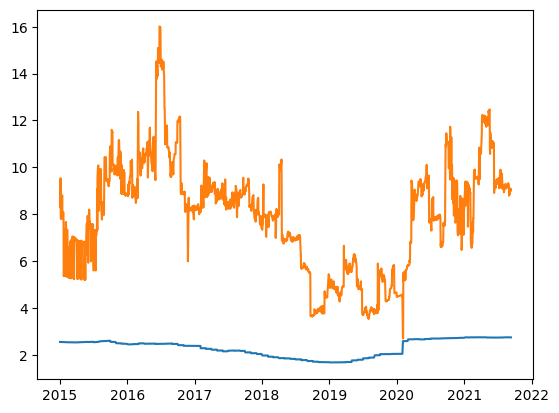

In [172]:
plt.plot(apple_temp.index, temp_imp_spread_apple)
plt.plot(apple_temp.index, apple_temp['PX1'])